In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OneHotEncoder

# from ipynb.fs.full.Functions import factorial

RANDOM_SEED = 1235846
import warnings
warnings.filterwarnings("ignore")

In [2]:
def model_predictions(model, x_train, y_train, x_test=None, y_test=None):

    '''Enter model name and test/train sets to generate predictions, precision, recall, accuracy, and F1 score'''
    model.fit(x_train, y_train)
    y_hat_train = model.predict(x_train)
    if x_test is not None:
        y_hat_test = model.predict(x_test)
    print('Training Precision: ', precision_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing Precision: ', precision_score(y_test, y_hat_test))
    print('-----')

    print('Training Recall: ', recall_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing Recall: ', recall_score(y_test, y_hat_test))
    print('-----')

    print('Training Accuracy: ', accuracy_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing Accuracy: ', accuracy_score(y_test, y_hat_test))
    print('-----')

    print('Training F1-Score: ', f1_score(y_train, y_hat_train))
    if x_test is not None:
        print('Testing F1-Score: ', f1_score(y_test, y_hat_test))
    if x_test is not None:
        return precision_score(y_test, y_hat_test), accuracy_score(y_test, y_hat_test)
    return precision_score(y_train, y_hat_train), accuracy_score(y_train, y_hat_train)

In [3]:
features_df = pd.read_csv('./data/flu_training_set_features.csv', index_col='respondent_id')
labels_df = labels_df = pd.read_csv("./data/flu_training_set_labels.csv", index_col="respondent_id")

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    features_df,
    labels_df,
    test_size=0.25,
    random_state=RANDOM_SEED
)

In [5]:
drop_features = ['hhs_geo_region', 'employment_industry','employment_occupation']
X_train.drop(drop_features, axis=1, inplace=True)
X_test.drop(drop_features, axis=1, inplace=True)
numeric_features = [col for col in X_train.columns if X_train[col].dtype != 'O']
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'O']

In [6]:
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median", add_indicator=True))]
)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [7]:
models = {'Baseline':
              {'regressor': DummyRegressor(),
               'preprocessor': preprocessor},
          'Logistic':
              {'regressor': LogisticRegression(),
               'preprocessor': preprocessor},
          'Naive_Bayes':
              {'regressor': GaussianNB(),
               'preprocessor': preprocessor},
          'Decision_Trees':
              {'regressor': DecisionTreeClassifier(),
               'preprocessor': preprocessor},
          'KNN':
              {'regressor': KNeighborsClassifier(),
               'preprocessor': preprocessor},
          'Random_Forest':
              {'regressor': RandomForestClassifier(),
               'preprocessor': preprocessor},
          'G_Boost':
              {'regressor': GradientBoostingClassifier(),
               'preprocessor': preprocessor},
          'Hist_Boost':
              {'regressor': HistGradientBoostingClassifier(),
               'preprocessor': preprocessor}
              }

In [8]:
count = 0
precision_dict = {}
accuracy_dict = {}
for name, model in models.items():  
    print(name)
    X_train_processed = model['preprocessor'].fit_transform(X_train)
    X_test_processed = model['preprocessor'].transform(X_test)
    model['fit_regressor'] = model['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
    # model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
    print(model)
    if count > 0:
        precision_dict[name], accuracy_dict[name] = model_predictions(model['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)
    count += 1

Baseline
{'regressor': DummyRegressor(), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                                  'opinion_h1n1_risk',
                                  'opi

## Baseline

In [9]:
# Using only 1 column as predicator
base_X_train = X_train.copy()
base_X_train.drop(base_X_train.columns.difference(['opinion_seas_risk']), 1, inplace=True)
base_X_test = X_test.copy()
base_X_test.drop(base_X_test.columns.difference(['opinion_seas_risk']), 1, inplace=True)

Baseline
{'Baseline': {'regressor': LogisticRegression(), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                                  'opinion_h1n1_risk',
                     

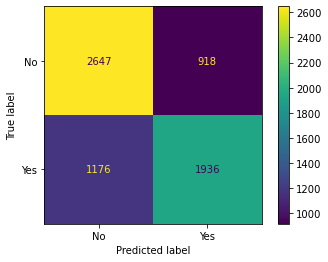

In [10]:
model_baseline = {'Baseline':
              {'regressor': LogisticRegression(),
               'preprocessor': preprocessor}}
 
print(list(model_baseline.keys())[0])
base_X_train.fillna(value=2, inplace=True)
base_X_test.fillna(value=2, inplace=True)
model_baseline['Baseline']['fit_regressor'] = model_baseline['Baseline']['regressor'].fit(base_X_train, y_train.seasonal_vaccine)
print(model_baseline)
precision_dict['Baseline'], accuracy_dict['Baseline'] = model_predictions(model_baseline['Baseline']['fit_regressor'], base_X_train, y_train.seasonal_vaccine, base_X_test, y_test.seasonal_vaccine)

y_hat_test_baseline = model_baseline['Baseline']['fit_regressor'].predict(base_X_test)
cm_baseline = confusion_matrix(y_test.seasonal_vaccine, y_hat_test_baseline)
ConfusionMatrixDisplay(cm_baseline, display_labels=['No', 'Yes']).plot()

In [11]:
precision_dict

{'Logistic': 0.7746526601152152,
 'Naive_Bayes': 0.6257470119521913,
 'Decision_Trees': 0.6606217616580311,
 'KNN': 0.7037037037037037,
 'Random_Forest': 0.7766101694915254,
 'G_Boost': 0.7829744279946165,
 'Hist_Boost': 0.7783283779319459,
 'Baseline': 0.6783461807988788}

In [12]:
accuracy_dict

{'Logistic': 0.7766961210124307,
 'Naive_Bayes': 0.6851879586640707,
 'Decision_Trees': 0.6824921371873596,
 'KNN': 0.7184364235435076,
 'Random_Forest': 0.7783435674704209,
 'G_Boost': 0.785831960461285,
 'Hist_Boost': 0.7862812640407368,
 'Baseline': 0.6863861015426089}

## Tuning Naive Bayes

In [13]:
# # Grid_search for Naive Bayes
# pipeline_nb = Pipeline([( "preprocessor" , preprocessor),
#                        ("nb",GaussianNB())])

# parameters_nb = {'nb__var_smoothing': np.logspace(0,-9, num=10)}

# gs_nb=GridSearchCV(pipeline_nb,parameters_nb)

# gs_nb.fit(X_train,y_train.seasonal_vaccine)

# gs_nb.best_params_

In [14]:
# nb_tuned = GaussianNB(var_smoothing=1.0)
# precision_dict[name], accuracy_dict[name] = model_predictions(nb_tuned, X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

In [15]:
# def best_param_model(model_name, regressor, parameters, X_train, y_train, X_test, y_test):
#     model_tuned = {model_name:
#               {'regressor': regressor(),
#                'preprocessor': preprocessor}}
                     
#     print(list(model_tuned.keys())[0])
#     X_train_processed = model_tuned[model_name]['preprocessor'].fit_transform(X_train)
#     X_test_processed = model_tuned[model_name]['preprocessor'].transform(X_test)
#     model_tuned[model_name]['fit_regressor'] = model_tuned[model_name]['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
#     # model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
#     print(model_tuned)
#     precision_dict[name], accuracy_dict[name] = model_predictions(model_tuned[model_name]['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)
    

In [16]:
precision_dict_tuned = {}
accuracy_dict_tuned = {}

In [18]:
model_nb_tuned = {'Naive_Bayes':
              {'regressor': GaussianNB(var_smoothing=1.0),
               'preprocessor': preprocessor}}
 
print(list(model_nb_tuned.keys())[0])
X_train_processed = model_nb_tuned['Naive_Bayes']['preprocessor'].fit_transform(X_train)
X_test_processed = model_nb_tuned['Naive_Bayes']['preprocessor'].transform(X_test)
model_nb_tuned['Naive_Bayes']['fit_regressor'] = model_nb_tuned['Naive_Bayes']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_nb_tuned)
precision_dict_tuned['Naive_Bayes'], accuracy_dict_tuned['Naive_Bayes'] = model_predictions(model_nb_tuned['Naive_Bayes']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)


Naive_Bayes
{'Naive_Bayes': {'regressor': GaussianNB(var_smoothing=1.0), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                                  'opinion_h1n1_risk',
      

## Tuning Random Forest

In [19]:
# # Grid_search for Random Forest
# pipeline_rfc = Pipeline([( "preprocessor" , preprocessor),
#                        ("rfc",RandomForestClassifier())])

# parameters_rfc = {}
# parameters_rfc['rfc__criterion'] = ['gini', 'entropy']
# parameters_rfc['rfc__min_samples_leaf'] = [1, 5, 10]
# parameters_rfc['rfc__max_depth'] = [1, 3, 5, 10, 15, 25]

# gs_rfc=GridSearchCV(pipeline_rfc,parameters_rfc)

# gs_rfc.fit(X_train,y_train.seasonal_vaccine)

# gs_rfc.best_params_

In [20]:
model_rfc_tuned = {'Random_Forest':
              {'regressor': RandomForestClassifier(criterion='gini', max_depth=15, min_samples_leaf=5),
               'preprocessor': preprocessor}}
 
print(list(model_rfc_tuned.keys())[0])
X_train_processed = model_rfc_tuned['Random_Forest']['preprocessor'].fit_transform(X_train)
X_test_processed = model_rfc_tuned['Random_Forest']['preprocessor'].transform(X_test)
model_rfc_tuned['Random_Forest']['fit_regressor'] = model_rfc_tuned['Random_Forest']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_rfc_tuned)
precision_dict_tuned['Random_Forest'], accuracy_dict_tuned['Random_Forest'] = model_predictions(model_rfc_tuned['Random_Forest']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)


Random_Forest
{'Random_Forest': {'regressor': RandomForestClassifier(max_depth=15, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                              

## Tuning Random Forest #2

In [21]:
# # Grid_search for Random Forest #2
# pipeline_rfc = Pipeline([( "preprocessor" , preprocessor),
#                        ("rfc",RandomForestClassifier(criterion='gini', min_samples_leaf=5))])

# parameters_rfc = {}
# parameters_rfc['rfc__max_depth'] = [3, 5]
# parameters_rfc['rfc__ccp_alpha'] = [0, 0.1, 0.5, 1, 2]
# parameters_rfc['rfc__n_estimators'] = [50, 100, 250, 500]


# gs_rfc=GridSearchCV(pipeline_rfc,parameters_rfc)

# gs_rfc.fit(X_train,y_train.seasonal_vaccine)

# gs_rfc.best_params_

In [22]:
model_rfc_tuned = {'Random_Forest':
              {'regressor': RandomForestClassifier(criterion='gini', max_depth=5, min_samples_leaf=5, n_estimators=500),
               'preprocessor': preprocessor}}
 
print(list(model_rfc_tuned.keys())[0])
X_train_processed = model_rfc_tuned['Random_Forest']['preprocessor'].fit_transform(X_train)
X_test_processed = model_rfc_tuned['Random_Forest']['preprocessor'].transform(X_test)
model_rfc_tuned['Random_Forest']['fit_regressor'] = model_rfc_tuned['Random_Forest']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_rfc_tuned)
precision_dict_tuned['Random_Forest'], accuracy_dict_tuned['Random_Forest'] = model_predictions(model_rfc_tuned['Random_Forest']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)


Random_Forest
{'Random_Forest': {'regressor': RandomForestClassifier(max_depth=5, min_samples_leaf=5, n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
             

## Tuning Random Forest #3

In [23]:
# # Randomized_search for Random Forest #3
# pipeline_rfc = Pipeline([( "preprocessor" , preprocessor),
#                        ("rfc",RandomForestClassifier(min_samples_leaf=5, max_depth=5, n_estimators=100))])

# parameters_rfc = {}
# parameters_rfc['rfc__criterion'] = ['gini', 'entropy']
# parameters_rfc['rfc__max_features'] = [9, 11, 15, 19]

# gs_rfc=RandomizedSearchCV(pipeline_rfc,parameters_rfc)

# gs_rfc.fit(X_train,y_train.seasonal_vaccine)

# gs_rfc.best_params_

In [24]:
# model_rfc_tuned = {'Random_Forest':
#               {'regressor': RandomForestClassifier(criterion='entropy', max_depth=5, min_samples_leaf=5, n_estimators=500, max_features=11),
#                'preprocessor': preprocessor}}
 
# print(list(model_rfc_tuned.keys())[0])
# X_train_processed = model_rfc_tuned['Random_Forest']['preprocessor'].fit_transform(X_train)
# X_test_processed = model_rfc_tuned['Random_Forest']['preprocessor'].transform(X_test)
# model_rfc_tuned['Random_Forest']['fit_regressor'] = model_rfc_tuned['Random_Forest']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# # model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
# print(model_rfc_tuned)
# precision_dict_tuned['Random_Forest'], accuracy_dict_tuned['Random_Forest'] = model_predictions(model_rfc_tuned['Random_Forest']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)


## Tuning Gradient Boosting

In [25]:
# # Grid_search for Gradient Boosting
# pipeline_gbc = Pipeline([( "preprocessor" , preprocessor),
#                        ("gbc",GradientBoostingClassifier(n_estimators=100, learning_rate=0.1))])

# parameters_gbc = {}
# parameters_gbc['gbc__min_samples_leaf'] = [1, 5, 10]
# parameters_gbc['gbc__max_depth'] = [3, 5, 10, 15, 20]

# gs_gbc=GridSearchCV(pipeline_gbc,parameters_gbc)

# gs_gbc.fit(X_train,y_train.seasonal_vaccine)

# gs_gbc.best_params_

Gradient_Boosting
{'Gradient_Boosting': {'regressor': GradientBoostingClassifier(max_depth=5, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                   

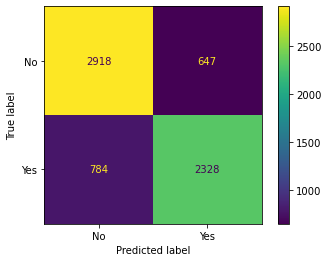

In [26]:
model_gbc_tuned = {'Gradient_Boosting':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5),
               'preprocessor': preprocessor}}
 
print(list(model_gbc_tuned.keys())[0])
X_train_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].transform(X_test)
model_gbc_tuned['Gradient_Boosting']['fit_regressor'] = model_gbc_tuned['Gradient_Boosting']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_gbc_tuned)
precision_dict_tuned['Gradient_Boosting'], accuracy_dict_tuned['Gradient_Boosting'] = model_predictions(model_gbc_tuned['Gradient_Boosting']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

y_hat_test_gbc = model_gbc_tuned['Gradient_Boosting']['fit_regressor'].predict(X_test_processed)
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test_gbc)
ConfusionMatrixDisplay(cm_gbc, display_labels=['No', 'Yes']).plot()

### Tuning Gradient Boost #2

In [ ]:
# Grid_search for Gradient Boosting #2
pipeline_gbc = Pipeline([( "preprocessor" , preprocessor),
                       ("gbc",GradientBoostingClassifier(n_estimators=500, learning_rate=0.1))])

parameters_gbc = {}
parameters_gbc['gbc__min_samples_leaf'] = [1, 5, 10]
parameters_gbc['gbc__max_depth'] = [3, 5, 10, 15, 20]

gs_gbc=GridSearchCV(pipeline_gbc,parameters_gbc)

gs_gbc.fit(X_train,y_train.seasonal_vaccine)

gs_gbc.best_params_

Gradient_Boosting
{'Gradient_Boosting': {'regressor': GradientBoostingClassifier(learning_rate=0.01, max_depth=5, min_samples_leaf=5,
                           n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                   

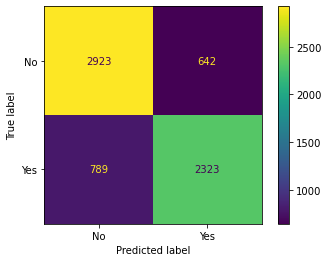

In [47]:
model_gbc_tuned = {'Gradient_Boosting':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5, n_estimators=500, learning_rate=0.01),
               'preprocessor': preprocessor}}
 
print(list(model_gbc_tuned.keys())[0])
X_train_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].transform(X_test)
model_gbc_tuned['Gradient_Boosting']['fit_regressor'] = model_gbc_tuned['Gradient_Boosting']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_gbc_tuned)
precision_dict_tuned['Gradient_Boosting'], accuracy_dict_tuned['Gradient_Boosting'] = model_predictions(model_gbc_tuned['Gradient_Boosting']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

y_hat_test_gbc = model_gbc_tuned['Gradient_Boosting']['fit_regressor'].predict(X_test_processed)
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test_gbc)
ConfusionMatrixDisplay(cm_gbc, display_labels=['No', 'Yes']).plot()

Gradient_Boosting
{'Gradient_Boosting': {'regressor': GradientBoostingClassifier(learning_rate=0.001, max_depth=6, min_samples_leaf=5), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective'

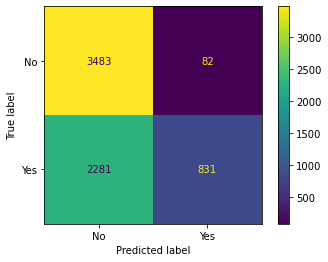

In [49]:
model_gbc_tuned = {'Gradient_Boosting':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=6, n_estimators=100, learning_rate=0.001),
               'preprocessor': preprocessor}}
 
print(list(model_gbc_tuned.keys())[0])
X_train_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].transform(X_test)
model_gbc_tuned['Gradient_Boosting']['fit_regressor'] = model_gbc_tuned['Gradient_Boosting']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_gbc_tuned)
precision_dict_tuned['Gradient_Boosting'], accuracy_dict_tuned['Gradient_Boosting'] = model_predictions(model_gbc_tuned['Gradient_Boosting']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

y_hat_test_gbc = model_gbc_tuned['Gradient_Boosting']['fit_regressor'].predict(X_test_processed)
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test_gbc)
ConfusionMatrixDisplay(cm_gbc, display_labels=['No', 'Yes']).plot()

Gradient_Boosting
{'Gradient_Boosting': {'regressor': GradientBoostingClassifier(learning_rate=0.001, max_depth=5, min_samples_leaf=5,
                           n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                  

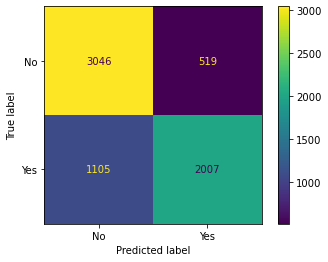

In [57]:
model_gbc_tuned = {'Gradient_Boosting':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5, n_estimators=500, learning_rate=0.001),
               'preprocessor': preprocessor}}
 
print(list(model_gbc_tuned.keys())[0])
X_train_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].transform(X_test)
model_gbc_tuned['Gradient_Boosting']['fit_regressor'] = model_gbc_tuned['Gradient_Boosting']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_gbc_tuned)
precision_dict_tuned['Gradient_Boosting'], accuracy_dict_tuned['Gradient_Boosting'] = model_predictions(model_gbc_tuned['Gradient_Boosting']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

y_hat_test_gbc = model_gbc_tuned['Gradient_Boosting']['fit_regressor'].predict(X_test_processed)
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test_gbc)
ConfusionMatrixDisplay(cm_gbc, display_labels=['No', 'Yes']).plot()

Gradient_Boosting
{'Gradient_Boosting': {'regressor': GradientBoostingClassifier(learning_rate=0.0005, max_depth=6,
                           min_samples_leaf=5, n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                 

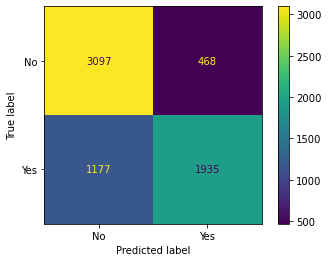

In [52]:
model_gbc_tuned = {'Gradient_Boosting':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=6, n_estimators=500, learning_rate=0.0005),
               'preprocessor': preprocessor}}
 
print(list(model_gbc_tuned.keys())[0])
X_train_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].transform(X_test)
model_gbc_tuned['Gradient_Boosting']['fit_regressor'] = model_gbc_tuned['Gradient_Boosting']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_gbc_tuned)
precision_dict_tuned['Gradient_Boosting'], accuracy_dict_tuned['Gradient_Boosting'] = model_predictions(model_gbc_tuned['Gradient_Boosting']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

y_hat_test_gbc = model_gbc_tuned['Gradient_Boosting']['fit_regressor'].predict(X_test_processed)
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test_gbc)
ConfusionMatrixDisplay(cm_gbc, display_labels=['No', 'Yes']).plot()

Gradient_Boosting
{'Gradient_Boosting': {'regressor': GradientBoostingClassifier(learning_rate=0.001, max_depth=7, min_samples_leaf=5,
                           n_estimators=500), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                  

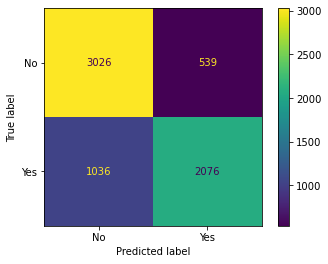

In [50]:
model_gbc_tuned = {'Gradient_Boosting':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=7, n_estimators=500, learning_rate=0.001),
               'preprocessor': preprocessor}}
 
print(list(model_gbc_tuned.keys())[0])
X_train_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].fit_transform(X_train)
X_test_processed = model_gbc_tuned['Gradient_Boosting']['preprocessor'].transform(X_test)
model_gbc_tuned['Gradient_Boosting']['fit_regressor'] = model_gbc_tuned['Gradient_Boosting']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_gbc_tuned)
precision_dict_tuned['Gradient_Boosting'], accuracy_dict_tuned['Gradient_Boosting'] = model_predictions(model_gbc_tuned['Gradient_Boosting']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

y_hat_test_gbc = model_gbc_tuned['Gradient_Boosting']['fit_regressor'].predict(X_test_processed)
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test_gbc)
ConfusionMatrixDisplay(cm_gbc, display_labels=['No', 'Yes']).plot()

## Tuning Hist Boost

In [101]:
# Grid_search for Hist Boost
pipeline_hbc = Pipeline([( "preprocessor" , preprocessor),
                       ("hbc",HistGradientBoostingClassifier(learning_rate=0.1, max_iter=100,))])

parameters_hbc = {}
parameters_hbc['hbc__min_samples_leaf'] = [5, 10]
parameters_hbc['hbc__max_depth'] = [5, 10, 15]

gs_hbc=GridSearchCV(pipeline_hbc,parameters_hbc)

gs_hbc.fit(X_train,y_train.seasonal_vaccine)

gs_hbc.best_params_

{'hbc__max_depth': 5, 'hbc__min_samples_leaf': 5}

In [28]:
model_hbc_tuned = {'Hist_Boosting':
              {'regressor': HistGradientBoostingClassifier(max_depth=10, min_samples_leaf=10),
               'preprocessor': preprocessor}}
 
print(list(model_hbc_tuned.keys())[0])
X_train_processed = model_hbc_tuned['Hist_Boosting']['preprocessor'].fit_transform(X_train)
X_test_processed = model_hbc_tuned['Hist_Boosting']['preprocessor'].transform(X_test)
model_hbc_tuned['Hist_Boosting']['fit_regressor'] = model_hbc_tuned['Hist_Boosting']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_hbc_tuned)
precision_dict_tuned['Hist_Boosting'], accuracy_dict_tuned['Hist_Boosting'] = model_predictions(model_hbc_tuned['Hist_Boosting']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)


Hist_Boosting
{'Hist_Boosting': {'regressor': HistGradientBoostingClassifier(max_depth=10, min_samples_leaf=10), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                     

Hist_Boosting
{'Hist_Boosting': {'regressor': HistGradientBoostingClassifier(max_depth=9, min_samples_leaf=10), 'preprocessor': ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='median'))]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face', 'doctor_recc_h1n1'...
                                  'opinion_h1n1_vacc_effective',
                      

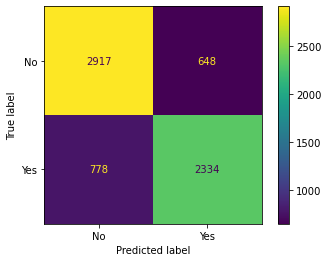

In [81]:
model_hbc_tuned = {'Hist_Boosting':
              {'regressor': HistGradientBoostingClassifier(max_depth=9, min_samples_leaf=10, learning_rate=0.1),
               'preprocessor': preprocessor}}
 
print(list(model_hbc_tuned.keys())[0])
X_train_processed = model_hbc_tuned['Hist_Boosting']['preprocessor'].fit_transform(X_train)
X_test_processed = model_hbc_tuned['Hist_Boosting']['preprocessor'].transform(X_test)
model_hbc_tuned['Hist_Boosting']['fit_regressor'] = model_hbc_tuned['Hist_Boosting']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_hbc_tuned)
precision_dict_tuned['Hist_Boosting'], accuracy_dict_tuned['Hist_Boosting'] = model_predictions(model_hbc_tuned['Hist_Boosting']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

y_hat_test_hbc = model_hbc_tuned['Hist_Boosting']['fit_regressor'].predict(X_test_processed)
cm_hbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test_hbc)
ConfusionMatrixDisplay(cm_hbc, display_labels=['No', 'Yes']).plot()

In [85]:
precision_dict

{'Logistic': 0.7746526601152152,
 'Naive_Bayes': 0.6257470119521913,
 'Decision_Trees': 0.6606217616580311,
 'KNN': 0.7037037037037037,
 'Random_Forest': 0.7766101694915254,
 'G_Boost': 0.7829744279946165,
 'Hist_Boost': 0.7783283779319459,
 'Baseline': 0.6783461807988788}

In [84]:
accuracy_dict

{'Logistic': 0.7766961210124307,
 'Naive_Bayes': 0.6851879586640707,
 'Decision_Trees': 0.6824921371873596,
 'KNN': 0.7184364235435076,
 'Random_Forest': 0.7783435674704209,
 'G_Boost': 0.785831960461285,
 'Hist_Boost': 0.7862812640407368,
 'Baseline': 0.6863861015426089}

In [83]:
precision_dict_tuned

{'Naive_Bayes': 0.6908442330558858,
 'Random_Forest': 0.7852941176470588,
 'Gradient_Boosting': 0.7945368171021377,
 'Hist_Boosting': 0.7826961770623743}

In [82]:
accuracy_dict_tuned

{'Naive_Bayes': 0.7262243522540063,
 'Random_Forest': 0.7663621386850382,
 'Gradient_Boosting': 0.7567769956567321,
 'Hist_Boosting': 0.7864310319005542}

In [89]:
precision_v = [v for v in precision_dict.values()]
precision_v

[0.7746526601152152,
 0.6257470119521913,
 0.6606217616580311,
 0.7037037037037037,
 0.7766101694915254,
 0.7829744279946165,
 0.7783283779319459,
 0.6783461807988788]

In [90]:
precision_k = [k for k in precision_dict.keys()]
precision_k

['Logistic',
 'Naive_Bayes',
 'Decision_Trees',
 'KNN',
 'Random_Forest',
 'G_Boost',
 'Hist_Boost',
 'Baseline']

In [123]:
precision_v_tuned = [v for v in precision_dict_tuned.values()]
precision_v_tuned

[0.6908442330558858,
 0.7852941176470588,
 0.7945368171021377,
 0.7826961770623743]

In [122]:
precision_k_tuned = [k for k in precision_dict_tuned.keys()]
precision_k_tuned

['Naive_Bayes', 'Random_Forest', 'Gradient_Boosting', 'Hist_Boosting']

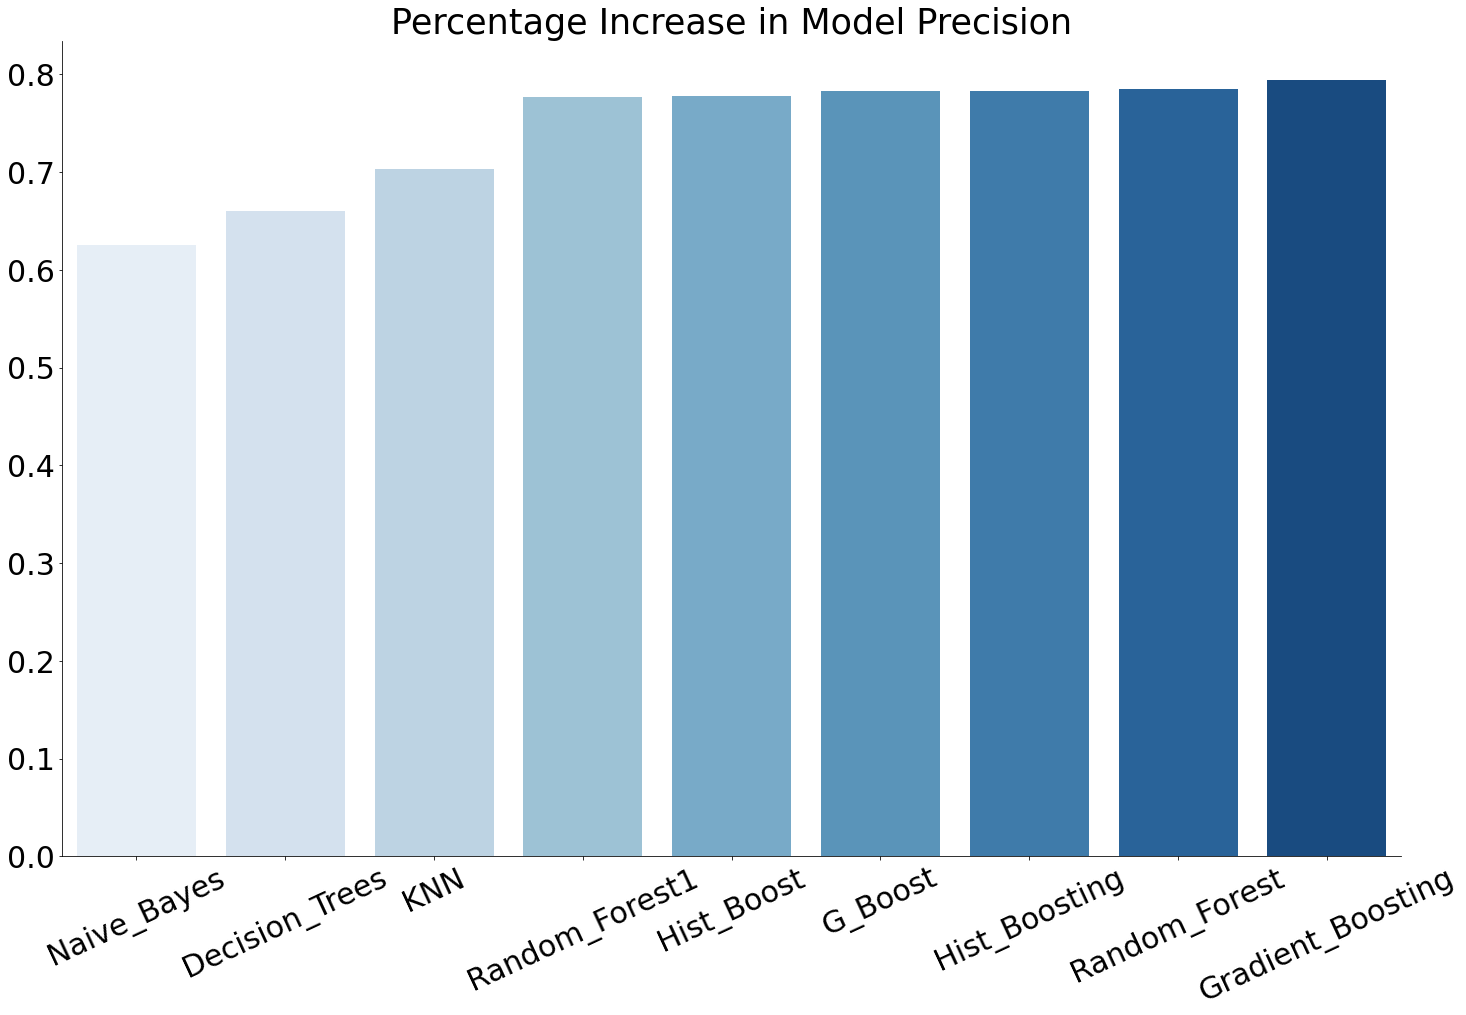

In [99]:
precision = [precision_v[1], precision_v[2], precision_v[3], precision_v[4], precision_v[6], precision_v[5], precision_v_tuned[3], precision_v_tuned[1], precision_v_tuned[2]]
names = [precision_k[1], precision_k[2], precision_k[3], precision_k[4]+'_1', precision_k[6], precision_k[5], precision_k_tuned[3], precision_k_tuned[1], precision_k_tuned[2]]

fig, ax = plt.subplots(figsize=(24, 15))
x_label = names
ax = sns.barplot(x_label, precision, palette="Blues")
plt.xticks(rotation=25, size=30)
plt.yticks(size=30)
sns.despine()
ax.set_title('Percentage Increase in Model Precision', fontsize=35)
# plt.savefig('Skyler_graph', bbox_inches='tight');

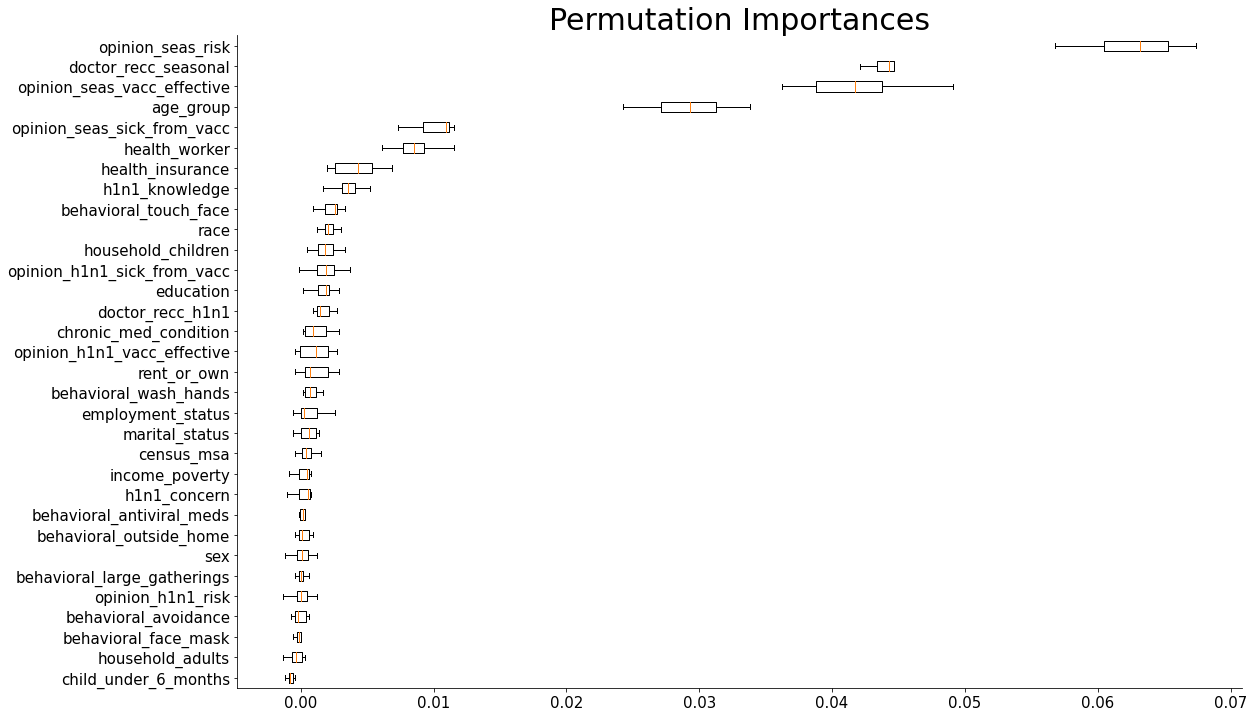

In [121]:
result = permutation_importance(
    gs_hbc, X_test, y_test.seasonal_vaccine, n_repeats=10, random_state=RANDOM_SEED, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(18, 12))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx], showfliers=False
)

ax.set_title("Permutation Importances", fontsize=30)
plt.xticks(size=15)
plt.yticks(size=15)
sns.despine()
# ax.set_ylim(bottom=25.5, top=32.5)

# plt.savefig('Permutation_Importances2', bbox_inches='tight');

In [ ]:
model_x_tuned = {'Gradient_Boosting':
              {'regressor': GradientBoostingClassifier(min_samples_leaf=5, max_depth=5, n_estimators=500, learning_rate=0.01),
               'preprocessor': preprocessor}}
 
print(list(model_gbc_tuned.keys())[0])
X_train_processed = model_x_tuned['Gradient_Boosting']['preprocessor'].fit_transform(X_train)
X_test_processed = model_x_tuned['Gradient_Boosting']['preprocessor'].transform(X_test)
model_x_tuned['Gradient_Boosting']['fit_regressor'] = model_x_tuned['Gradient_Boosting']['regressor'].fit(X_train_processed, y_train.seasonal_vaccine)
# model['output'] = model['fit_regressor'].score(X_test_processed, y_test.seasonal_vaccine)
print(model_x_tuned)
model_predictions(model_x_tuned['Gradient_Boosting']['fit_regressor'], X_train_processed, y_train.seasonal_vaccine, X_test_processed, y_test.seasonal_vaccine)

y_hat_test_gbc = model_x_tuned['Gradient_Boosting']['fit_regressor'].predict(X_test_processed)
cm_gbc = confusion_matrix(y_test.seasonal_vaccine, y_hat_test_gbc)
ConfusionMatrixDisplay(cm_gbc, display_labels=['No', 'Yes']).plot()